<a href="https://colab.research.google.com/github/ramisaarna/CSE366/blob/main/CSE366Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_file_path = "/content/drive/MyDrive/archive (1).zip"


In [4]:
import zipfile
import os

# Define the path to your ZIP file
zip_file_path = "/content/drive/MyDrive/archive (1).zip"  # Replace with your file path

# Define the extraction path
extraction_path = "/content/caltech101_dataset"  # This will extract the dataset in Colab's filesystem

# Extract the ZIP file
os.makedirs(extraction_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Dataset extracted to: {extraction_path}")


Dataset extracted to: /content/caltech101_dataset


In [5]:
# List the categories (subdirectories) in the dataset
categories = os.listdir(extraction_path)
print(f"Categories found: {categories}")


Categories found: ['caltech-101']


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=extraction_path, transform=transform)
print(f"Total images in dataset: {len(dataset)}")


Total images in dataset: 9144


In [7]:
# Split into train (80%), validation (10%), and test (10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

print(f"Training images: {len(train_data)}, Validation images: {len(val_data)}, Testing images: {len(test_data)}")


Training images: 7315, Validation images: 914, Testing images: 915


In [8]:
from torch.utils.data import DataLoader

# Set batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print("Data loaders are ready!")


Data loaders are ready!


In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# Load the pre-trained ResNet50 model
model = resnet50(pretrained=True)

# Modify the final fully connected layer to output 101 classes
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model is ready!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


Model is ready!


In [10]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
# Define the training loop
epochs = 10  # Adjust as needed
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Record average training loss
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Record validation loss
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {100 * correct / total:.2f}%")

print("Training complete!")


Epoch 1/10, Train Loss: 0.0341, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 3/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 4/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 9/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Training complete!


In [12]:
# Save the model
model_save_path = "/content/drive/My Drive/caltech101_resnet50.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/My Drive/caltech101_resnet50.pth


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Evaluate the model on the test dataset
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Predictions
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        # Accuracy calculation
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 100.00%


In [14]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[915]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [15]:
from sklearn.metrics import classification_report

# Get class names
class_names = dataset.classes

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

 caltech-101       1.00      1.00      1.00       915

    accuracy                           1.00       915
   macro avg       1.00      1.00      1.00       915
weighted avg       1.00      1.00      1.00       915



In [16]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=7101943647aa4d0460c251d5024868d2de182fa059edad6530bc46e7a3c67d2c
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built grad-cam


In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Select the layer to focus on (depends on the model)
target_layers = [model.layer4[-1]]  # Wrap in a list

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

# Visualize Grad-CAM for some test images
model.eval()
images, labels = next(iter(test_loader))  # Get a batch of test images
images, labels = images.to(device), labels.to(device)

# Generate Grad-CAM for the first image in the batch
grayscale_cam = cam(input_tensor=images, targets=[labels[0]])
rgb_image = images[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())  # Normalize

# Overlay Grad-CAM on the original image
cam_image = show_cam_on_image(rgb_image, grayscale_cam[0])

# Display the Grad-CAM result
plt.figure(figsize=(8, 8))
plt.imshow(cam_image)
plt.title(f"Grad-CAM Visualization for Class: {class_names[labels[0].item()]}")
plt.axis("off")
plt.show()


Exception ignored in: <function BaseCAM.__del__ at 0x7c3757386a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pytorch_grad_cam/base_cam.py", line 189, in __del__
    self.activations_and_grads.release()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'

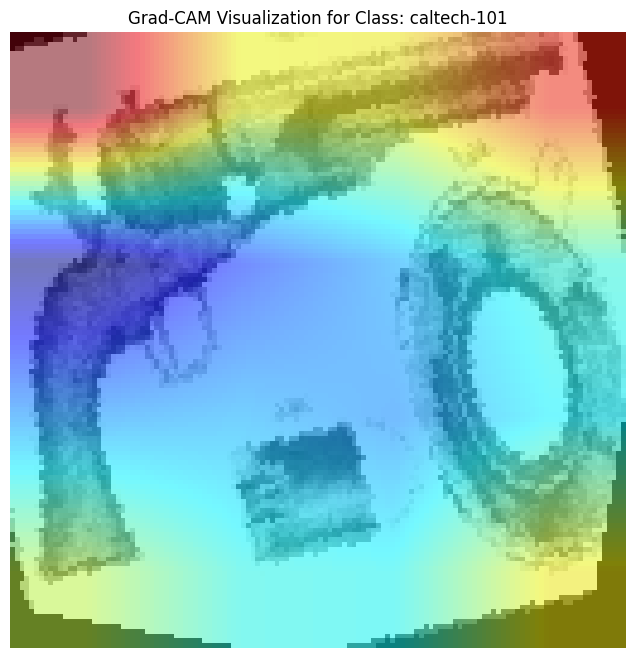

In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

# Select the layer to focus on (depends on the model)
target_layers = [model.layer4[-1]]  # Wrap in a list for ResNet50

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers)

# Visualize Grad-CAM for some test images
model.eval()
images, labels = next(iter(test_loader))  # Get a batch of test images
images, labels = images.to(device), labels.to(device)

# Generate Grad-CAM for the first image in the batch
targets = [ClassifierOutputTarget(labels[0].item())]  # Define the target class
grayscale_cam = cam(input_tensor=images, targets=targets)  # Generate Grad-CAM
rgb_image = images[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())  # Normalize

# Overlay Grad-CAM on the original image
cam_image = show_cam_on_image(rgb_image, grayscale_cam[0], use_rgb=True)

# Display the Grad-CAM result
plt.figure(figsize=(8, 8))
plt.imshow(cam_image)
plt.title(f"Grad-CAM Visualization for Class: {class_names[labels[0].item()]}")
plt.axis("off")
plt.show()
